<a href="https://colab.research.google.com/github/100jy/dacon_workout/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%9A%B4%EB%8F%99%EB%8F%99%EC%9E%91_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning

     |████████████████████████████████| 696kB 7.5MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 829kB 14.6MB/s 
     |████████████████████████████████| 276kB 34.1MB/s 
     |████████████████████████████████| 1.3MB 38.0MB/s 
     |████████████████████████████████| 296kB 47.2MB/s 
     |████████████████████████████████| 143kB 58.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=0044852beb0a9e55b3a0b37f77ffb4ed5d3cdf99c4dbc614e456327cee12b8d1
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=c4bf247a47ed9f4068915f3c0d59110863bfb94d82b18364118ad664409d69d3
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
os.chdir('/content/drive/MyDrive/데이콘')

In [4]:
train_df=pd.read_csv('train_features.csv')
train_df.values.max(axis=1).shape

(1875000,)

In [5]:
def get_data():
  train_df=pd.read_csv('train_features.csv')
  train_labels_df=pd.read_csv('train_labels.csv')
  test=pd.read_csv('test_features.csv')

  train_labels_df['label'].astype('category')
  train_labels_df = pd.get_dummies(train_labels_df)

  #scaling 
  eps = 1e-5
  '''
  train_val = train_df.values.reshape(-1,600,8)
  max_val = np.abs(train_val).max(axis=1, keepdims=True) + eps
  train_val /=  max_val

  test_val = test.values.reshape(-1,600,8)
  max_val = np.abs(test_val).max(axis=1, keepdims=True) + eps
  test.iloc[:,:] = (test_val/max_val).reshape(-1,8)
  '''
  train_val = train_df.values.reshape(-1,600,8)
  max_val = np.abs(train_val).max(axis=0, keepdims=True) + eps
  train_val /=  max_val

  test_val = test.values.reshape(-1,600,8)
  test.iloc[:,:] = (test_val/max_val).reshape(-1,8)

  return train_val, train_labels_df['label'], test 

train, train_labels, _ = get_data()

# EDA

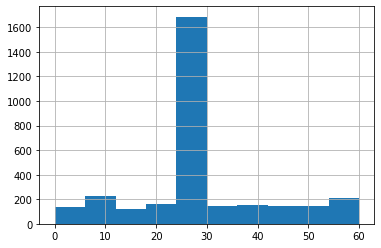

In [86]:
train_labels.hist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  


torch.Size([301])


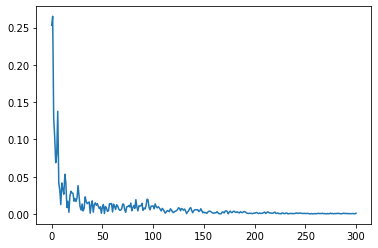

In [6]:
#FFT
fft = torch.rfft(torch.tensor(train[[3],:,3], dtype=torch.float32), 2, normalized=True)
mag = (fft[0,:,0]**2 + fft[0,:,1]**2).sqrt()
plt.plot(mag)
print(mag.shape)

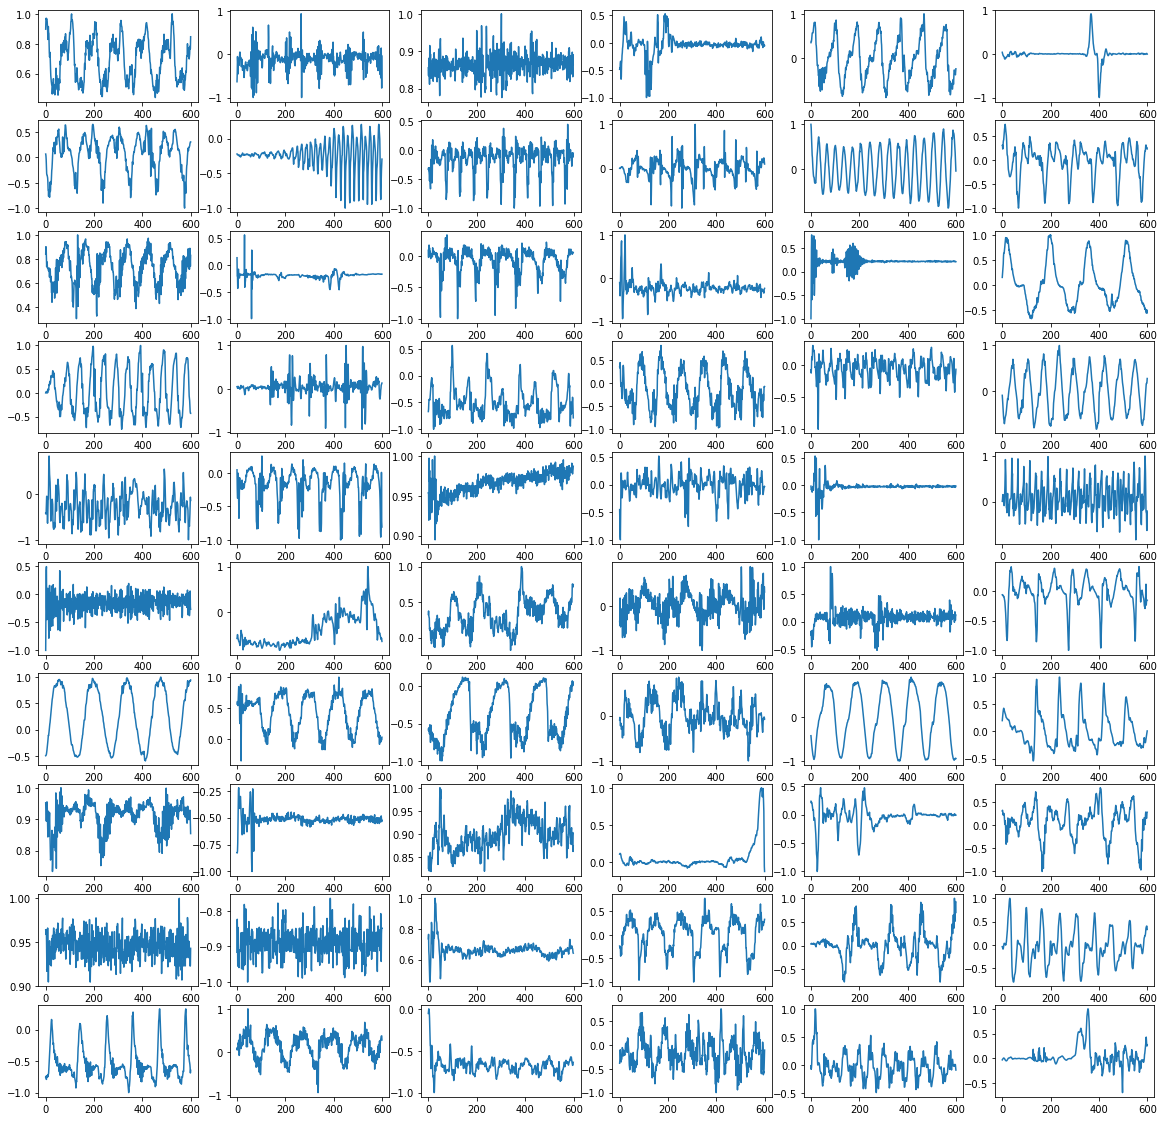

In [20]:
n_rows = 10
n_cols = 6

mask =  (train_labels != 26)
plt.figure(figsize=(20,20))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(train[mask][index,:,col+2])
plt.show()

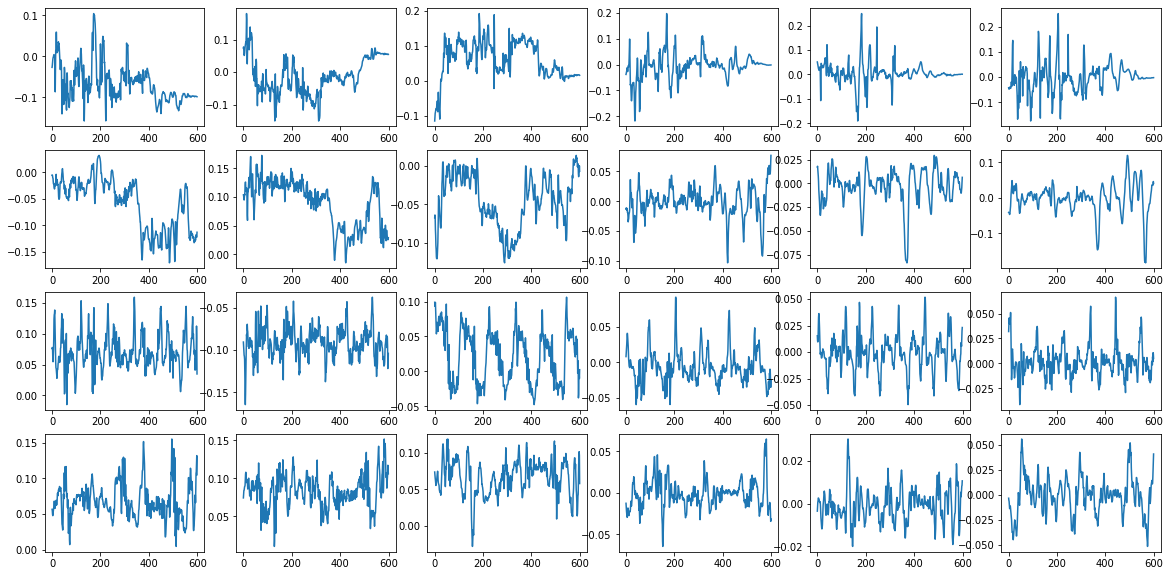

In [8]:
n_rows = 4
n_cols = 6

plt.figure(figsize=(20,10))
n = 0
for row in range(n_rows-2):
  while  train_labels.values[n] != 0:
      n += 1
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(train[n,:,col+2])
  n += 1

n = 0
for row in range(2, n_rows):
  while  train_labels.values[n] != 1:
      n += 1
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(train[n,:,col+2])
  n += 1
plt.show()

# Dataloader

In [6]:
class DatasetSignals(Dataset):
  def __init__(self, signal=train, label_df=train_labels, device='cuda', random_factor=None, test=False):
    super(DatasetSignals, self).__init__()
    self.device = device
    self.test = test

    self.scaling_lower_bound = random_factor.get('scaling_lower_bound')
    self.scaling_upper_bound = random_factor.get('scaling_upper_bound')
    self.stretch_lower_bound = random_factor.get('stretch_lower_bound')

    #make cache
    self.signal = torch.tensor(signal[:,:,2:], dtype=torch.float32)
    self.label = torch.tensor(label_df.values, dtype=torch.int64, device=device)
    

  def __len__(self):
    return len(self.signal)
  
  def __getitem__(self, idx):
    seq_len = 600
    x = torch.zeros(600,6, dtype=torch.float32, device=self.device)
  
    # random scaling(lower_bound~1)
    lower_bound = self.scaling_lower_bound
    upper_bound = self.scaling_upper_bound
    scale_factor = (upper_bound-lower_bound)*torch.rand(1) + lower_bound
    
    # random stretch
    lower_bound = self.stretch_lower_bound
    stretch_factor =  (1-lower_bound)*torch.rand(1) + lower_bound
    new_len = int(seq_len * stretch_factor)

    # slower
    cut_len = (seq_len - new_len)//2 + 1
    new_signal =  self.signal[[idx], cut_len:-cut_len, :] 
    new_signal = F.interpolate(new_signal.transpose(-1,-2), size=seq_len).squeeze(0).transpose(-1,-2)

    # random shifting & scaling
    shift_factor = np.random.randint(1, 600)
    x[:,:] = scale_factor * torch.roll(new_signal, shift_factor, dims=0)
    
    if self.test:
      return x
    # 400,6
    return x, self.label[idx]

In [7]:
  def make_sampler(train_labels):
    weight = 1/train_labels.value_counts()
    weight[26] *= 4
    weight_label = []
    
    for val in train_labels:
      weight_label.append(weight[val])

    samples_weight = torch.from_numpy(np.array(weight_label))
    samples_weight = samples_weight.double()
    sampler =  torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(train_labels))
    return sampler

In [8]:
config = {'scaling_lower_bound':0.9,
          'scaling_upper_bound':1.1,
             'stretch_lower_bound':0.9}

dataset = DatasetSignals(random_factor=config)

(torch.Size([600, 6]), torch.Size([]))

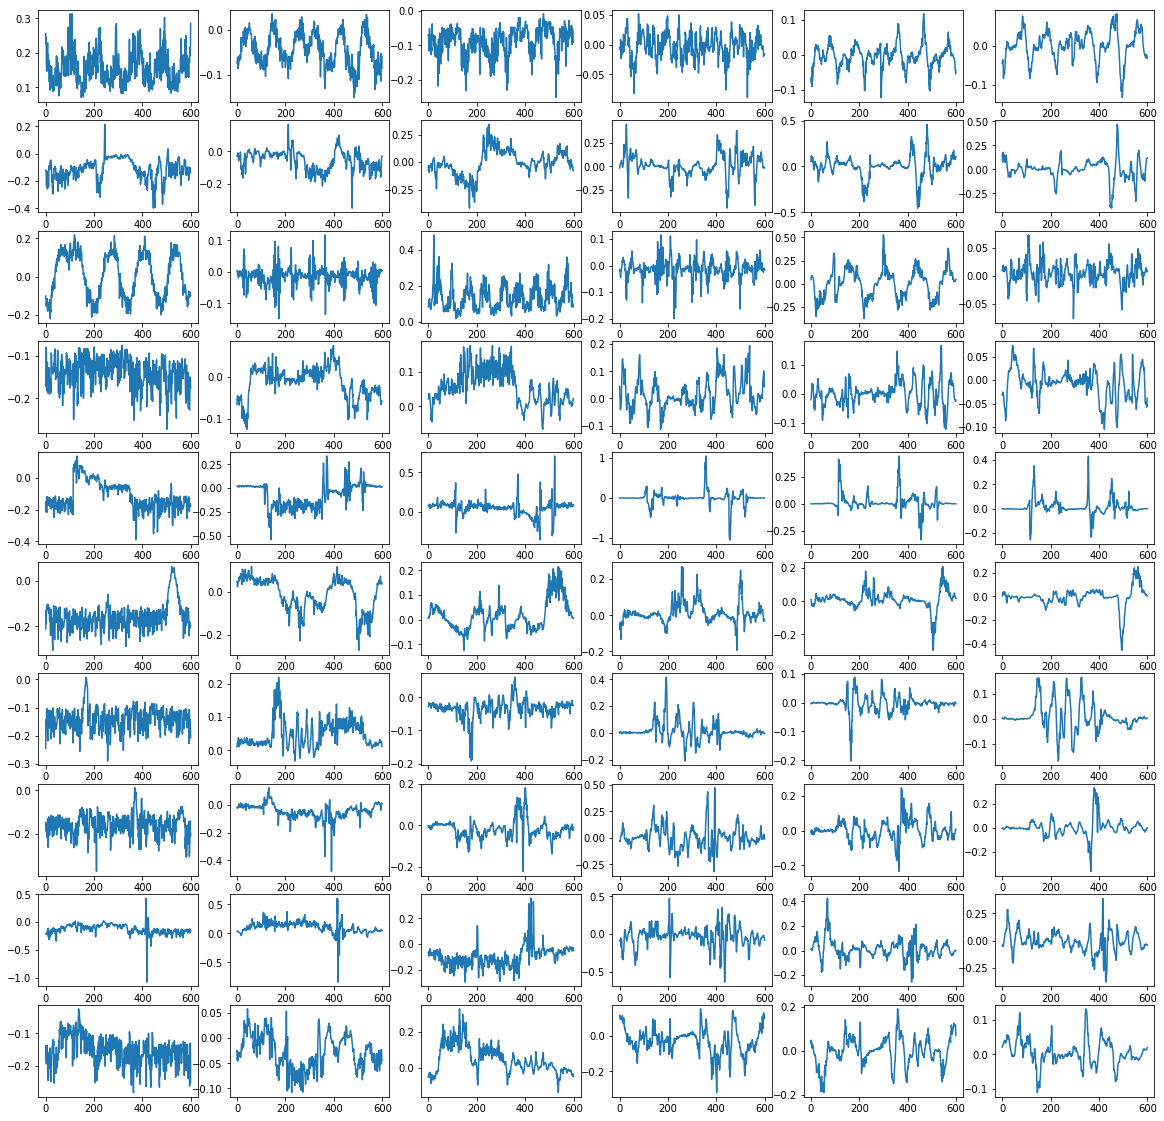

In [9]:
n_rows=10
n_cols=6
plt.figure(figsize=(20,20))
for row in range(n_rows):
    value = dataset.__getitem__(row)[0].detach().cpu().numpy()
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.plot((value[...,col]))

dataset.__getitem__(0)[0].shape, dataset.__getitem__(0)[1].shape


# Model

In [10]:
class ConvNet(nn.Module):
    def __init__(self,config=None, input_ch=3):
        super(ConvNet, self).__init__()
        input_len = 600
        self.config = config
        self.out_len = input_len//(2**4)
        self.conv = nn.Sequential(nn.Conv1d(input_ch, 64, 3, 1, padding=1), nn.BatchNorm1d(64), nn.ReLU(),  
                                  nn.MaxPool1d(2,2),
                                  nn.BatchNorm1d(64),
                                  nn.Conv1d(64, 128, 3, 1,padding=1), nn.BatchNorm1d(128),nn.ReLU(),
                                  nn.MaxPool1d(2,2),
                                  nn.BatchNorm1d(128),
                                  nn.Conv1d(128, 256, 3, 1,padding=1), nn.BatchNorm1d(256),nn.ReLU(),
                                  nn.MaxPool1d(2,2),
                                  nn.BatchNorm1d(256),
                                  nn.Conv1d(256, 512, 3, 1,padding=1), nn.BatchNorm1d(512),nn.ReLU(),
                                  nn.MaxPool1d(2,2),
                                  nn.BatchNorm1d(512),
                                  nn.Conv1d(512, 512, 3, 1,padding=1), nn.BatchNorm1d(512),nn.ReLU(),
                                  nn.MaxPool1d(self.out_len)
                                  )
        
        self.fc = nn.Linear(512, 61)   
        
    def forward(self, x):
        x = self.conv(x.transpose(-1,-2))
        x = self.fc(x.squeeze())
        x = F.dropout(x, self.config.get('dropout_p'))
        return x



# 변수별로 독립 seq로 regression
class ParallelConv(nn.Module):
  def __init__(self, config=None):
    super(ParallelConv, self).__init__()
    self.config = config

    self.feature_1 = ConvNet(config)
    self.feature_2 = ConvNet(config)

    self.last = nn.Linear(61*2,61)
  
  def forward(self, x_time):
    
    seq_1 = self.feature_1(x_time[:,:,:3])
    seq_2 = self.feature_2(x_time[:,:,3:])
    
    #B 61*3
    out = torch.cat([seq_1, seq_2], dim=-1)
    out = self.last(out)
    # B 61
    return (out.squeeze(-1))

# lightning wrapper

In [11]:
class Model(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        
        self.loss = torch.nn.CrossEntropyLoss()
        self. model =  ParallelConv(config).cuda()
        self.accuracy = pl.metrics.Accuracy()
        self.config = config

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred_label = self.model(x)
        loss = self.loss(pred_label, y)
        #self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
      for i in range(10):
        x, y = val_batch
        if i == 0:
          pred_label = self.model(x)
        else:
          pred_label += self.model(x)
      pred_label /= 10
      loss = self.loss(pred_label, y)
      acc = self.accuracy(torch.argmax(pred_label, dim=1), y)
      return {'val_loss': loss, 'acc' : acc}
    
    def validation_epoch_end(self, outputs):
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      acc = torch.stack([x['acc'] for x in outputs]).mean()
      #tensorboard_logs = {'val_loss': avg_loss}
      #self.log('val_loss', avg_loss)
      if self.config.get('print_val_loss'):
        print("Epoch {} | val_loss:{:-10.3f},  acc:{:-10.3f}".format(self.current_epoch, avg_loss, acc))
      return {'val_loss': avg_loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,
                                verbose=False)
        
        if self.config.get('use_scheduler'):
          return [optimizer],[scheduler]
        return optimizer

# fitting

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
n_fold = 2
signal, labels, test = get_data()
skf = StratifiedKFold(n_splits=n_fold)

# 13
for train_index, val_index in tqdm(skf.split(signal, labels)):
  train, train_labels =  signal[train_index], labels[train_index]
  val, val_labels = signal[val_index], labels[val_index]
  # to handle data imbalance 
  batch_size = 32
  sampler = make_sampler(train_labels)

  config = {'scaling_lower_bound':0.9,
            'scaling_upper_bound':1.1,
            'stretch_lower_bound':0.9,
            'dropout_p':0.7,
            'print_val_loss' :True,
            'use_scheduler':True}

  train_data = DatasetSignals(train, train_labels, random_factor=config)
  val_data = DatasetSignals(val, val_labels, random_factor=config)
  model = Model(config).cuda()

  checkpoint_callback = ModelCheckpoint(
      monitor='val_loss',
      filename='model-{val_loss:.3f}',
      save_top_k=3,
      mode='min',)
  
  trainer = pl.Trainer(progress_bar_refresh_rate=0, gpus=1, max_epochs=50, callbacks=[checkpoint_callback], weights_summary=None)
  trainer.fit(model, DataLoader(train_data, batch_size=batch_size, sampler=sampler), DataLoader(val_data, batch_size=128))

# Prediction

In [ ]:
from tqdm import tqdm
num_re=100
with torch.no_grad():
  test_data = DatasetSignals(test.values.reshape(-1, 600, 8), random_factor=config, test=True)
  loader = DataLoader(test_data, batch_size=len(test.values.reshape(-1, 600, 8)))
  dir_list = []
  for i in range(0, n_fold):
    dir_list.append('lightning_logs/version_{}/checkpoints/'.format(i))
  for iter, dir in tqdm(enumerate(dir_list)):
    model = dir + sorted(os.listdir(dir))[0]
    pretrained_model = Model.load_from_checkpoint(model, config=config).cuda()
    pretrained_model.eval()
    pretrained_model.freeze()

    for i in range(num_re):          
      for test_X in loader:
        if i == 0 and iter==0:
          prediction = pretrained_model(test_X)
        else:
          prediction += pretrained_model(test_X)

  prediction /= num_re*len(dir_list)  
  prediction = F.softmax(prediction)  

# 기타 함수

In [15]:
def maek_prediction(test, n_fold, n_repeats, num_re=100):
  from tqdm import tqdm

  with torch.no_grad():
    test_data = DatasetSignals(test.values.reshape(-1, 600, 8), random_factor=config, test=True)
    loader = DataLoader(test_data, batch_size=len(test.values.reshape(-1, 600, 8)))
    dir_list = []
    for i in range(0, n_fold*n_repeats):
      dir_list.append('lightning_logs/version_{}/checkpoints/'.format(i))
    for iter, dir in tqdm(enumerate(dir_list)):
      model = dir + sorted(os.listdir(dir))[0]
      pretrained_model = Model.load_from_checkpoint(model, config=config).cuda()
      pretrained_model.eval()
      pretrained_model.freeze()

      for i in range(num_re):          
        for test_X in loader:
          if i == 0 and iter==0:
            prediction = pretrained_model(test_X)
          else:
            prediction += pretrained_model(test_X)

    prediction /= num_re*len(dir_list)  
    prediction = F.softmax(prediction)  
    return prediction

In [22]:
def train_models(config, n_fold=50, max_epochs=100, n_repeats=10):
  from sklearn.model_selection import RepeatedStratifiedKFold
  from tqdm import tqdm

  signal, labels, test = get_data()
  skf = RepeatedStratifiedKFold(n_splits=n_fold, n_repeats=n_repeats)
  for train_index, val_index in tqdm(skf.split(signal, labels)):
    train, train_labels =  signal[train_index], labels[train_index]
    val, val_labels = signal[val_index], labels[val_index]
    # to handle data imbalance 
    sampler = make_sampler(train_labels)

    train_data = DatasetSignals(train, train_labels, random_factor=config)
    val_data = DatasetSignals(val, val_labels, random_factor=config)
    model = Model(config).cuda()

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='model-{val_loss:.3f}',
        save_top_k=3,
        mode='min',)
    
    trainer = pl.Trainer(progress_bar_refresh_rate=0, gpus=1, max_epochs=max_epochs, callbacks=[checkpoint_callback], weights_summary=None)
    trainer.fit(model, DataLoader(train_data, batch_size=32, sampler = sampler), DataLoader(val_data, batch_size=128))

In [21]:
def make_output(config, train=True):
  n_fold, num_re, max_epochs = config.get('n_fold'),  config.get('num_re'), config.get('max_epochs')
  n_repeats =  config.get('n_repeats')
  if train:
    train_models(config, n_fold, max_epochs, n_repeats)
  _, _, test = get_data()
  prediction = maek_prediction(test, n_fold, n_repeats, num_re)
  submission=pd.read_csv('sample_submission.csv')
  submission.iloc[:,1:] = prediction.detach().cpu().numpy()
  submission.to_csv('Resnet1d.csv', index=False)
  print('Saved result.')
  print(submission)

# 제출파일 생성

In [ ]:
config = {'scaling_lower_bound':0.9,
          'scaling_upper_bound':1.1,
          'stretch_lower_bound':0.9,
          'dropout_p':0.7,
          'print_val_loss' :False,
          'use_scheduler':True,
          'n_fold':10,
          'n_repeats':5,
          'max_epochs':100,
          'num_re':100}

make_output(config)

# 기록

----best record--------------------------------------
- simple (모델 수정)
- with aug (0.9 ~ 1.1)
- drop p 0.7
- repeated(10,5)
- 100 epoch
- sampler 적용
- scheduler 적용
- public score 0.5137(8등)

---검증필요------------------------------------------
- val loss 기준으로 비교 1.1 아래로 떨어지는 단일 모델 찾기


---효과 좋았던 것------------------------------------------
- optimizer adam, batch size 32
- Muticonv 사용 x
- augmentation
- dropout 높여보기
- TTS
- sklearn cv 활용 (stratify kfold)
- Max pooling
- random factor 증가

----Fix------------------------------------------
- weighted sampler 유무
  - loss상으로는 비슷한 성능
  - 논리상 맞으니 사용
- drop out rate
  - 0.5로 고정 
- 2 models or 6 models
  -개선없음
- RNN 효과
  - 효과 bad
- 스케듈러 효과
  - 별 효과x
- self attention 효과검증
  - 별 효과x